In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combine = [train, test]

In [3]:
print(train.info())
print('-'*40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

In [4]:
train.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [5]:
train.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Create new feature from SibSp and Parch - family size and is alone

In [6]:
for df in combine:
    df['family_size'] = df.SibSp + df.Parch + 1
    df['is_alone'] = np.where(df.family_size > 1, 0, 1)
    
    df.drop(['Parch', 'SibSp'], axis=1, inplace=True)
    
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,1,1


In [7]:
train.groupby('is_alone').Survived.mean()

is_alone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

Create new feature from Name - title

In [8]:
for df in combine:
    df['title'] = \
    (
        df.Name
        .str.lower()
        .str.extract('[^,]+, ([\w]+)\. .*')
        .replace(['mr', 'miss', 'mrs', 'master'], [0, 1, 2, 3])
    )

    df.loc[~df.title.isin([0, 1, 2, 3]), 'title'] = 4
    df.drop('Name', axis=1, inplace=True)

test.title.unique()

array([0, 2, 1, 3, 4], dtype=object)

In [9]:
train.groupby('title').Survived.mean()

title
0    0.156673
1    0.697802
2    0.792000
3    0.575000
4    0.444444
Name: Survived, dtype: float64

Filling age missing values. Identifying differentiating factors. Splitting into groups by them and taking median by group.

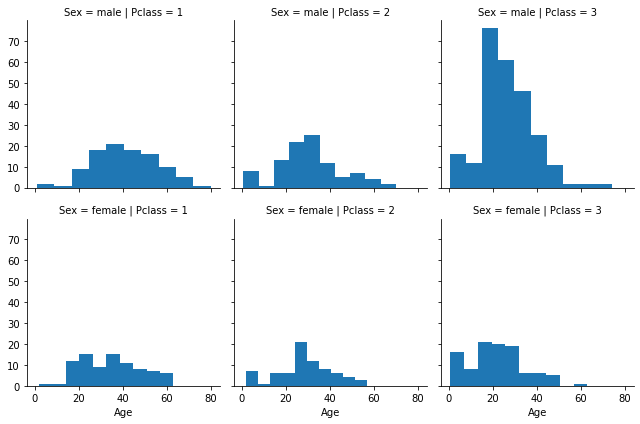

In [10]:
g = sns.FacetGrid(train, row='Sex', col='Pclass')
g.map(plt.hist, 'Age')

Guessing age for groups by class and sex

In [11]:
age_guesses = pd.concat(combine).groupby(['Pclass', 'Sex']).Age.median().tolist()

In [12]:
for df in combine:
    for idx, row in df.loc[df.Age.isnull()].iterrows():

        if row.Sex == 'female' and row.Pclass == 1:
            df.loc[idx, 'Age'] = age_guesses[0]

        elif row.Sex == 'male' and row.Pclass == 1:
            df.loc[idx, 'Age'] = age_guesses[1]

        elif row.Sex == 'female' and row.Pclass == 2:
            df.loc[idx, 'Age'] = age_guesses[2]

        elif row.Sex == 'male' and row.Pclass == 2:
            df.loc[idx, 'Age'] = age_guesses[3]

        elif row.Sex == 'female' and row.Pclass == 3:
            df.loc[idx, 'Age'] = age_guesses[4]

        else:
            df.loc[idx, 'Age'] = age_guesses[5]

train.Age.isnull().sum()

0

Filling Embarked with most common (it has only 2 missing values)

In [13]:
for df in combine:
    df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

train.Embarked.isnull().sum()

0

Converting Sex and Embarked to numeric categories

In [14]:
for df in combine:
    df['Sex'] = df.Sex.map({'male': 0, 'female': 1}).astype(int)
    df['Embarked'] = df.Embarked.map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,family_size,is_alone,title
0,1,0,3,0,22.0,A/5 21171,7.2500,NaN,0,2,0,0
1,2,1,1,1,38.0,PC 17599,71.2833,C85,1,2,0,2
2,3,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,0,1,1,1
3,4,1,1,1,35.0,113803,53.1000,C123,0,2,0,2
4,5,0,3,0,35.0,373450,8.0500,NaN,0,1,1,0


Filling Fare NA's with median

In [15]:
for df in combine:
    df.Fare = df.Fare.fillna(df.Fare.median())

## Converting continuous values to categorical

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
le = LabelEncoder()

Creating age and fare bins and replacing continuous with labels

In [18]:
for df in combine:
    
    df['age_bins'] = pd.qcut(df.Age, 5)
    df['fare_bins'] = pd.qcut(df.Fare, 5)
    
    df['age_bins'] = le.fit_transform(df.age_bins)
    df['fare_bins'] = le.fit_transform(df.fare_bins)


## Fitting the model

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Subsetting features and target variable, splitting for train and test

In [20]:
X = train.loc[:, ['Pclass', 'Sex', 'age_bins', 'fare_bins', 'Embarked', 'is_alone', 'family_size', 'title']]
y = train.Survived

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Decision Tree

Fitting decision tree classifier with grid search on cross-validation with roc_auc score

In [24]:
clf = DecisionTreeClassifier()

In [25]:
params = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(2, 20)
}

In [27]:
search = GridSearchCV(clf, param_grid=params, scoring='roc_auc', cv=5).fit(X_train, y_train)

In [ ]:
search.best_score_

In [ ]:
search.best_params_

In [ ]:
best_tree = search.best_estimator_

In [ ]:
y_hat = best_tree.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_hat)

Preparing test data and making predictions

In [36]:
test = \
(
    test
    .set_index('PassengerId')
    .loc[:, ['Pclass', 'Sex', 'age_bins', 'fare_bins', 'Embarked', 'is_alone', 'family_size', 'title']]
)

In [591]:
test['Survived'] = best_tree.predict(test)

In [592]:
test.Survived.reset_index().to_csv('submission_tree.csv', index=False)

### Random Forest

In [23]:
rf = RandomForestClassifier()

In [28]:
params = {
    'n_estimators': [10],
    'max_depth': range(3, 7),
    'min_samples_split': range(5, 15),
    'min_samples_leaf': range(5, 15)
}

In [54]:
search = GridSearchCV(rf, param_grid=params, scoring='roc_auc', cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(3, 7),
                         'min_samples_leaf': range(5, 15),
                         'min_samples_split': range(5, 15),
                         'n_estimators': [10]},
             scoring='roc_auc')

In [55]:
search.best_score_

0.8825837328886109

In [56]:
search.best_params_

{'max_depth': 4,
 'min_samples_leaf': 10,
 'min_samples_split': 13,
 'n_estimators': 10}

In [57]:
best_clf = search.best_estimator_

In [58]:
test_pred = best_clf.predict(test)

In [60]:
(
    pd.DataFrame({'Survived': test_pred}, index=test.index)
    .reset_index()
    .to_csv('submission_rf_roc_auc.csv', index=False)
)